In [1]:
#from IPython.display import clear_output as clr
#!wget https://universe.roboflow.com/...
#!unzip ...
#!mkdir train_xml
#!mkdir valid_xml
#!mv train/*.xml train_xml/
#!mv valid/*.xml valid_xml/
#clr()

In [2]:
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torchvision import utils
import torch.utils.data
import torchvision
from torchvision.models.detection import SSDLite320_MobileNet_V3_Large_Weights
from PIL import Image
import xml.etree.ElementTree as ET
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import torchvision.transforms as T
from sklearn.metrics import precision_recall_curve, auc
from torch.utils.tensorboard import SummaryWriter

In [3]:
random.seed(1)
os.environ['PYTHONHASHSEED'] = str(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
len(os.listdir('train')), len(os.listdir('train_xml'))

(5058, 5058)

In [5]:
class CigaretteDataset(torch.utils.data.Dataset):
    def __init__(self, transforms, img_dir, annot_dir, img_list, annot_list):
        self.transforms = transforms
        self.img_dir = img_dir
        self.annot_dir = annot_dir
        self.img_list = img_list
        self.annot_list = annot_list

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        annot_path = os.path.join(self.annot_dir, self.annot_list[idx])
        img = Image.open(img_path).convert("RGB")
        width, height = img.size
        img = np.array(img)
        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for member in root.findall('object'):
            labels.append(int(member[0].text == "cigarette") + 1)
            bbox = member.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            xmin = xmin / width
            ymin = ymin / height
            xmax = xmax / width
            ymax = ymax / height

            xmin = max(0, xmin)
            ymin = max(0, ymin)
            xmax = min(1, xmax)
            ymax = min(1, ymax)

            boxes.append([xmin, ymin, xmax, ymax])


        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])

        target = {}
        target["labels"] = labels
        target["image_id"] = image_id

        if self.transforms is not None:
            transformed = self.transforms(image=img, bboxes=boxes, labels=labels)
            img = transformed['image']
            boxes = transformed['bboxes']
        
        boxes = [[x1*512, y1*512, x2*512, y2*512] for (x1, y1, x2, y2) in boxes]
        
        if len(boxes) == 0:
            target["boxes"] = torch.zeros((0,4), dtype=torch.float32)
        else:
            target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)

        return img, target



    def __len__(self):
        return len(self.img_list)


def collate_fn(batch):
    return tuple(zip(*batch))

def train_transform():
    transform = A.Compose([
    A.Resize(512, 512, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.5, border_mode=0),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.GaussNoise(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
    ], bbox_params=A.BboxParams(format='albumentations', label_fields=['labels'], check_each_transform=True))
    return transform

def val_transform():
    transform = A.Compose([
    A.Resize(512, 512, always_apply=True),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
    ], bbox_params=A.BboxParams(format='albumentations', label_fields=['labels'], check_each_transform=True))
    return transform

In [6]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.history = defaultdict(lambda: {"train": [], "val": []})
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )
    def store(self, phase):
        for metric_name, metric in self.metrics.items():
            self.history[metric_name][phase].append(metric["avg"].item())

In [7]:
def get_model(num_classes):
    model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT)
    num_anchors = model.head.classification_head.module_list[0][1].out_channels // 91  # original num_classes for COCO

    for i in range(len(model.head.classification_head.module_list)):
        conv_layer = model.head.classification_head.module_list[i][1]
        conv_layer.out_channels = num_anchors * num_classes
        model.head.classification_head.module_list[i][1] = conv_layer

    return model


def train_one_epoch(model, optimizer, dataloader, device):
    model.train()
    monitor.reset()
    progress_bar = tqdm(dataloader, total=len(dataloader))
    for images, targets in progress_bar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        monitor.update('Loss', loss)
        progress_bar.set_description(str(monitor))


def evaluate(model, dataloader, device):
    model.eval()
    monitor.reset()
    progress_bar = tqdm(dataloader, total=len(dataloader))
    iou_values = []

    with torch.no_grad():
        for images, targets in progress_bar:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            preds = model(images)
            
            for pred, target in zip(preds, targets):
                pred_boxes = pred['boxes'].tolist()
                target_boxes = target['boxes'].tolist()
                for box1, box2 in zip(pred_boxes, target_boxes):
                    iou_values.append(bbox_iou(box1, box2))
            
            avg_iou = np.mean(iou_values)

            monitor.update('Val IoU', avg_iou)
            progress_bar.set_description(str(monitor))

In [8]:
def bbox_iou(box1, box2, eps=1e-7):
    b1_x1, b1_y1, b1_x2, b1_y2 = box1
    b2_x1, b2_y1, b2_x2, b2_y2 = box2

    inter_x1 = max(b1_x1, b2_x1)
    inter_y1 = max(b1_y1, b2_y1)
    inter_x2 = min(b1_x2, b2_x2)
    inter_y2 = min(b1_y2, b2_y2)

    inter_area = max(inter_x2 - inter_x1 + 1, 0) * max(inter_y2 - inter_y1 + 1, 0)

    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + eps)

    return iou

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2

model = get_model(num_classes)
model.to(device)

train_img_dir = 'train'
train_annot_dir = 'train_xml'
valid_img_dir = 'valid'
valid_annot_dir = 'valid_xml'

train_img_list = list(sorted(os.listdir(train_img_dir)))
train_annot_list = list(sorted(os.listdir(train_annot_dir)))
val_img_list = list(sorted(os.listdir(valid_img_dir)))
val_annot_list = list(sorted(os.listdir(valid_annot_dir)))

train_data = CigaretteDataset(train_transform(),
    train_img_dir, train_annot_dir, train_img_list, train_annot_list)
val_data = CigaretteDataset(val_transform(), valid_img_dir, valid_annot_dir, val_img_list, val_annot_list)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=64, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.005, steps_per_epoch=len(train_loader),
                                                   epochs=15)

monitor = MetricMonitor(float_precision=5)

num_epochs = 100
for epoch in range(num_epochs):
    print('Epoch '+str(epoch+1)+':')
    train_one_epoch(model, optimizer, train_loader, device)
    monitor.store('train')
    scheduler.step()
    evaluate(model, val_loader, device)
    monitor.store('val')

Epoch 1:


Val IoU: 0.18515: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch 2:


Val IoU: 0.20716: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch 3:


Val IoU: 0.19187: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch 4:


Val IoU: 0.20068: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Epoch 5:


Val IoU: 0.21079: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Epoch 6:


Val IoU: 0.23104: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


Epoch 7:


Val IoU: 0.22930: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch 8:


Val IoU: 0.23804: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch 9:


Val IoU: 0.24048: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch 10:


Val IoU: 0.22276: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch 11:


Val IoU: 0.23043: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 12:


Val IoU: 0.22516: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Epoch 13:


Val IoU: 0.24078: 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


Epoch 14:


Val IoU: 0.23069: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Epoch 15:


Val IoU: 0.24219: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


Epoch 16:


Val IoU: 0.26378: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


Epoch 17:


Val IoU: 0.24778: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


Epoch 18:


Val IoU: 0.23517: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


Epoch 19:


Val IoU: 0.25810: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


Epoch 20:


Val IoU: 0.25511: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


Epoch 21:


Val IoU: 0.22575: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


Epoch 22:


Val IoU: 0.21565: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


Epoch 23:


Val IoU: 0.24000: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 24:


Val IoU: 0.24345: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


Epoch 25:


Val IoU: 0.23566: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


Epoch 26:


Val IoU: 0.23639: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


Epoch 27:


Val IoU: 0.24522: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


Epoch 28:


Val IoU: 0.23649: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


Epoch 29:


Val IoU: 0.24576: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 30:


Val IoU: 0.22702: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


Epoch 31:


Val IoU: 0.23625: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


Epoch 32:


Val IoU: 0.26078: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


Epoch 33:


Val IoU: 0.26505: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 34:


Val IoU: 0.24871: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


Epoch 35:


Val IoU: 0.25713: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch 36:


Val IoU: 0.25827: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch 37:


Val IoU: 0.25312: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


Epoch 38:


Val IoU: 0.24894: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch 39:


Val IoU: 0.25271: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch 40:


Val IoU: 0.23575: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


Epoch 41:


Val IoU: 0.27827: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch 42:


Val IoU: 0.27276: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch 43:


Val IoU: 0.27696: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


Epoch 44:


Val IoU: 0.26173: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


Epoch 45:


Val IoU: 0.26275: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


Epoch 46:


Val IoU: 0.26560: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch 47:


Val IoU: 0.26744: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 48:


Val IoU: 0.27405: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 49:


Val IoU: 0.25847: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


Epoch 50:


Val IoU: 0.25948: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


Epoch 51:


Val IoU: 0.27641: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch 52:


Val IoU: 0.25930: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


Epoch 53:


Val IoU: 0.27741: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 54:


Val IoU: 0.25693: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch 55:


Val IoU: 0.26554: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 56:


Val IoU: 0.26758: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 57:


Val IoU: 0.25873: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


Epoch 58:


Val IoU: 0.25830: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


Epoch 59:


Val IoU: 0.27985: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


Epoch 60:


Val IoU: 0.25856: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch 61:


Val IoU: 0.24776: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


Epoch 62:


Val IoU: 0.25137: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 63:


Val IoU: 0.26004: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch 64:


Val IoU: 0.25762: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 65:


Val IoU: 0.25880: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch 66:


Val IoU: 0.27889: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 67:


Val IoU: 0.28043: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch 68:


Val IoU: 0.23840: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch 69:


Val IoU: 0.26351: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch 70:


Val IoU: 0.27363: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 71:


Val IoU: 0.24269: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch 72:


Val IoU: 0.27603: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 73:


Val IoU: 0.27297: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


Epoch 74:


Val IoU: 0.25580: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch 75:


Val IoU: 0.29480: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch 76:


Val IoU: 0.28754: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Epoch 77:


Val IoU: 0.24356: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


Epoch 78:


Val IoU: 0.26273: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 79:


Val IoU: 0.26215: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch 80:


Val IoU: 0.26522: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch 81:


Val IoU: 0.28490: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 82:


Val IoU: 0.27586: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


Epoch 83:


Val IoU: 0.24920: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


Epoch 84:


Val IoU: 0.27432: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 85:


Val IoU: 0.27050: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch 86:


Val IoU: 0.26791: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch 87:


Val IoU: 0.25997: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch 88:


Val IoU: 0.26920: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 89:


Val IoU: 0.27047: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


Epoch 90:


Val IoU: 0.29151: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


Epoch 91:


Val IoU: 0.25961: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 92:


Val IoU: 0.26337: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch 93:


Val IoU: 0.24646: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 94:


Val IoU: 0.25572: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch 95:


Val IoU: 0.24983: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 96:


Val IoU: 0.26764: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


Epoch 97:


Val IoU: 0.24699: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch 98:


Val IoU: 0.27684: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


Epoch 99:


Val IoU: 0.27791: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch 100:


Val IoU: 0.26234: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


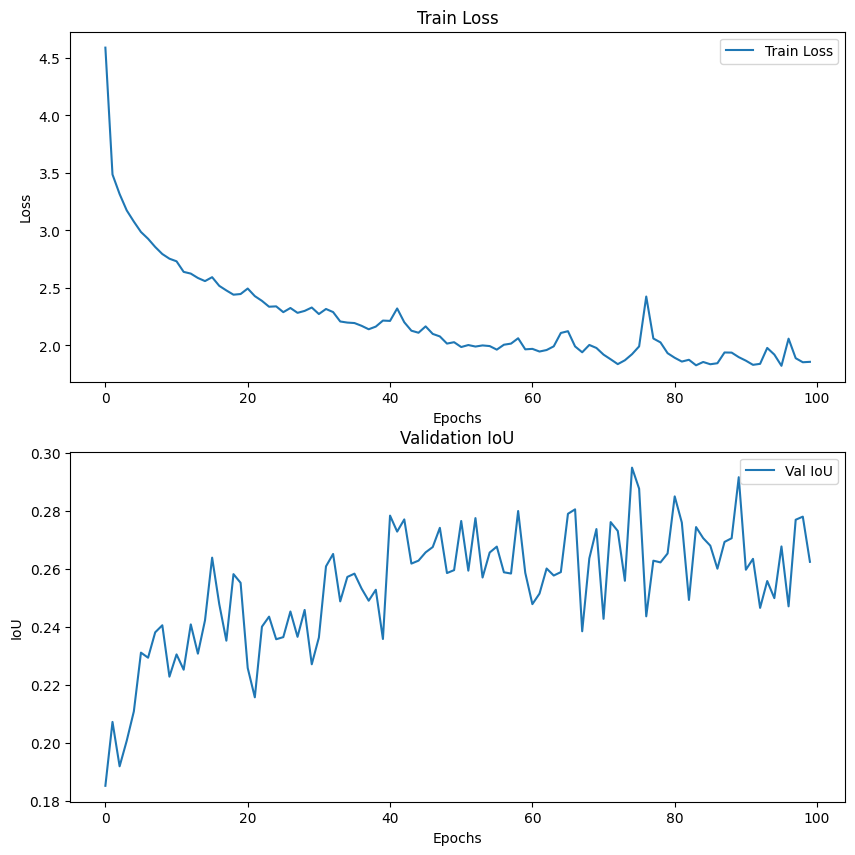

In [11]:
fig, axs = plt.subplots(2, figsize=(10,10))

axs[0].plot(monitor.history['Loss']['train'], label='Train Loss')
axs[0].set_title('Train Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

axs[1].plot(monitor.history['Val IoU']['val'], label='Val IoU')
axs[1].set_title('Validation IoU')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('IoU')

for ax in axs:
    ax.legend()

In [12]:
torch.save(model.state_dict(), "ssdlite_weights.pth")

(-0.5, 479.5, 359.5, -0.5)

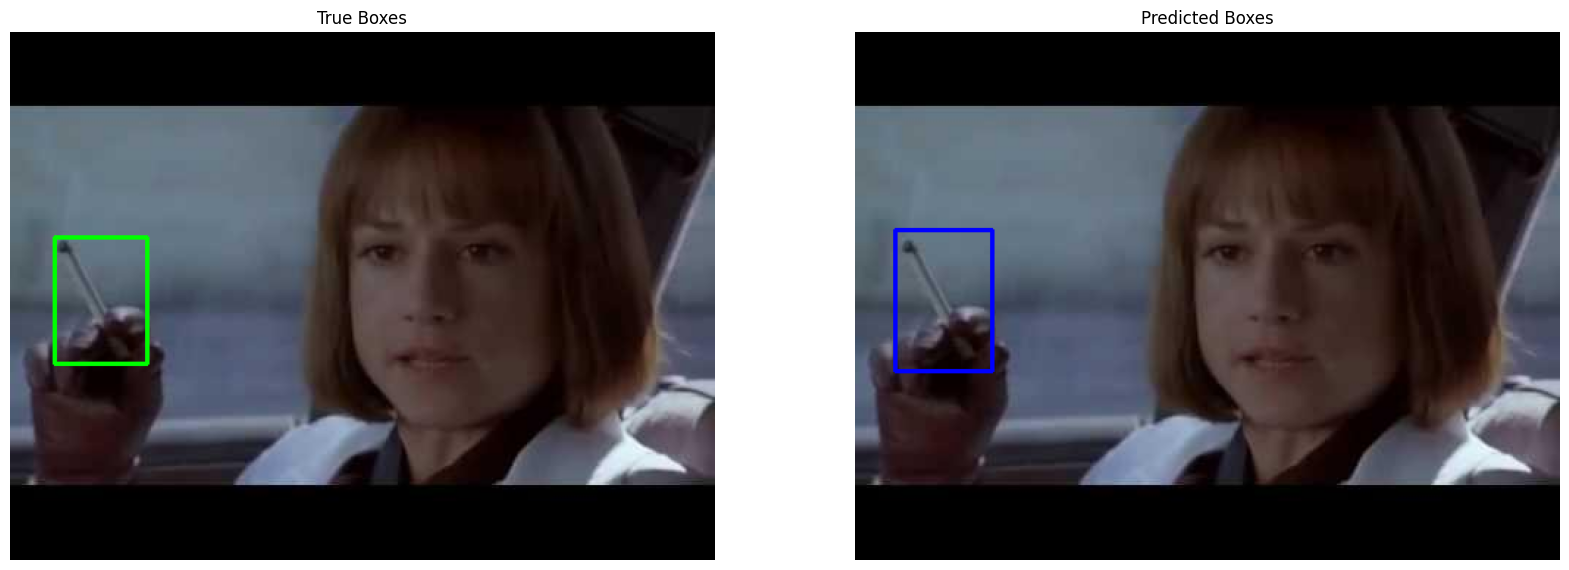

In [13]:
import xml.etree.ElementTree as ET
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

model.eval()

img_dir = 'valid'
img_list = list(sorted(os.listdir(img_dir)))
img_path = img_dir+'/'+img_list[3]


def get_test_transform():
    transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    return transform

image = Image.open(img_path)
transform = get_test_transform()
transformed_image = transform(image=np.array(image))['image'].unsqueeze(0)


with torch.no_grad():
    prediction = model(transformed_image.to(device))

annot_dir = 'valid_xml'
annot_path = annot_dir+'/'+img_list[3].replace('.jpg', '.xml')
tree = ET.parse(annot_path)
root = tree.getroot()


fig, axs = plt.subplots(1, 2, figsize=(20,10))

image_true_boxes = cv2.imread(img_path)

for obj in root.findall('object'):
    bbox = obj.find('bndbox')
    x1, y1, x2, y2 = int(bbox.find('xmin').text), int(bbox.find('ymin').text), int(bbox.find('xmax').text), int(bbox.find('ymax').text)
    cv2.rectangle(image_true_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)

axs[0].imshow(cv2.cvtColor(image_true_boxes, cv2.COLOR_BGR2RGB))
axs[0].set_title('True Boxes')
axs[0].axis('off')


image_pred_boxes = cv2.imread(img_path)

for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
    if score > 0.5:
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        cv2.rectangle(image_pred_boxes, (x1, y1), (x2, y2), (255, 0, 0), 2)

axs[1].imshow(cv2.cvtColor(image_pred_boxes, cv2.COLOR_BGR2RGB))
axs[1].set_title('Predicted Boxes')
axs[1].axis('off')

In [14]:
prediction

[{'boxes': tensor([[2.7384e+01, 1.3502e+02, 9.3783e+01, 2.3132e+02],
          [4.1695e+02, 5.2371e+01, 4.7856e+02, 2.2988e+02],
          [4.4612e+02, 2.3452e+02, 4.8000e+02, 2.6064e+02],
          [4.5423e+02, 2.3459e+02, 4.8000e+02, 2.7518e+02],
          [0.0000e+00, 2.7210e+02, 1.8855e+02, 3.1500e+02],
          [2.2115e+01, 1.7508e+02, 9.5127e+01, 2.2981e+02],
          [3.6917e+02, 5.3154e+01, 4.7777e+02, 2.0253e+02],
          [4.5324e+02, 2.1778e+02, 4.8000e+02, 2.5916e+02],
          [4.3980e+02, 2.2539e+02, 4.7596e+02, 2.4622e+02],
          [1.5421e+02, 0.0000e+00, 2.6701e+02, 2.4484e+01],
          [2.2730e+02, 1.3319e+02, 2.6967e+02, 2.1512e+02],
          [4.4570e+02, 2.4577e+02, 4.7730e+02, 2.7685e+02],
          [2.6332e+02, 2.5197e+02, 3.9840e+02, 3.0863e+02],
          [1.1587e+01, 9.6960e+01, 6.1897e+01, 1.8481e+02],
          [4.2719e+02, 2.3184e+02, 4.7428e+02, 2.5654e+02],
          [4.4124e+02, 6.7212e+01, 4.7982e+02, 2.2544e+02],
          [4.4943e+02, 1.4970e+